# Idea
Do some Plotting of singular features

| **Possible DataSources** |
| --- |
| SYS_data |
| KERN_data |
| FLS_data |
| RES_data |
| block_data |
| network_data |
| entropy_data |


In [1]:
DATA_SOURCE = "entropy_data"
DEVICE_SOURCE = "Heqing_device2"

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd

In [3]:
import sys
sys.path.append(str(Path("./../../../../").resolve()))

from py_dataset import get_all_files_df
from py_dataset import read_in_files
from py_dataset import feature_plotting

In [4]:
data_path = Path('/media/<User>/DC/MAP_CreationOfNewDatasetsForDFL/code&data/0_raw_collected_data/')
assert data_path.exists()

In [5]:
df = get_all_files_df.main(data_path)
df.head(1)

txt file found, will drop /media/<User>/DC/MAP_CreationOfNewDatasetsForDFL/code&data/0_raw_collected_data/Heqing/device1/3_thetick_4h/collections.txt
txt file found, will drop /media/<User>/DC/MAP_CreationOfNewDatasetsForDFL/code&data/0_raw_collected_data/Heqing/device2/1_normal/note.txt
                                           file_path
0  /media/<User>/DC/MAP_CreationOfNewDatasetsForDFL/...
RangeIndex(start=0, stop=622, step=1)
filetype
csv    530
zip     92
Name: count, dtype: int64
                                           file_path filetype  filesize_bytes
0  /media/<User>/DC/MAP_CreationOfNewDatasetsForDFL/...      csv           49419
feature_family
SYS_data        92
KERN_data       91
FLS_data        91
RES_data        91
block_data      91
network_data    91
entropy_data    75
Name: count, dtype: int64


,file_path,filetype,filesize_bytes,researcher_name,device_name,experiment,feature_family,file_name,device
0,/media//DC/MAP_CreationOfNewDatasetsForDFL/...,csv,49419,Heqing,device1,1_normal,block_data,e4_5f_01_68_35_e6.csv,Heqing_device1


#### Get Single data
* device = Xi_sensor_1 => most data rp3
* go through all features of each feature_family
    * for one 
        1. First: Sum up over all experiments/Malwares/labels first
        2. Then: Then only specific attack in comparison?
            * each column: normalize the data
            * plot boxplot: distribution

In [6]:
single_dev = df[df["device"] == DEVICE_SOURCE]
assert len(single_dev["device"].unique()) == 1

In [7]:
single_dev_single_data_source = single_dev[single_dev["feature_family"] == DATA_SOURCE]
assert len(single_dev_single_data_source["feature_family"].unique()) == 1
single_dev_single_data_source.shape

(19, 9)

In [8]:
vectors = read_in_files.get_all_columns_from_single_data_source_for_csv_files(single_dev_single_data_source)

In [9]:
vectors.head(1)

,file_path,action,entropy,experiment
timestamp,,,,
2023-11-09 15:18:56,/tmp/perf-vdso.so-mDAroA,CREATE,2.34667,1_normal


#### feature Engineering

In [10]:
# interval = 10000 # 10s

# current_time = start_timestamp
# results = []

# while current_time <= end_timestamp:
#     subset = df[(df['timestamp'] >= current_time) & (df['timestamp'] < current_time + interval)]
    
#     temp_table = subset[subset['entropy'] >= 6]
    
#     # remove duplicates
#     unique_files = temp_table['file_path'].unique()
    
#     results.append({'timestamp': current_time, 'entropy_file_count': len(unique_files)})
    
#     current_time += interval

In [11]:
def resample_high_entropy_grouping_by_label(df):
    df = df.copy()
    df.sort_index(inplace=True)

    series = []

    for label, group_df in df.groupby(df["experiment"]):
        for timestamp, group_df in group_df.resample("10s"):
            group_df = group_df[group_df["entropy"] >= 6]

            entropy_file_count = group_df["file_path"].nunique()
            series.append({'timestamp': timestamp, 'entropy_file_count': entropy_file_count, 'label': label})

    new_vectors = pd.DataFrame(series)
    new_vectors.set_index("timestamp", inplace=True, drop=True)
    return new_vectors

In [12]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

def get_file_type(file_path: str):
    file_path = Path(file_path)
    if not file_path.suffix[1:]:
        print("Found a file without type: ", file_path, file_path.suffix)
        return 'no_filetype'
    return file_path.suffix[1:]

def resample_high_entropy_grouping_by_label_and_filetype(df):
    df = df.copy()
    df.sort_index(inplace=True)
    df["file_type"] = df["file_path"].apply(get_file_type)

    series = []

    vocab =  df["file_type"].unique()
    vectorizer = CountVectorizer(vocabulary=vocab)


    for label, group_df in df.groupby(df["experiment"]):
        for timestamp, group_df in group_df.resample("10s"):
            group_df = group_df[group_df["entropy"] >= 5]

            doc = " ".join(group_df["file_type"])
            series.append({'timestamp': timestamp, 'doc': doc, 'label': label})
    
    new_vectors = pd.DataFrame(series)
    new_vectors.set_index("timestamp", inplace=True, drop=True)

    X = vectorizer.transform(new_vectors["doc"])

    transformer = TfidfTransformer()
    X_tf_idf = transformer.fit_transform(X).toarray()
    new_vectors.drop(columns=["doc"], inplace=True)
    new_vectors = pd.concat([new_vectors, pd.DataFrame(X_tf_idf, columns=vectorizer.get_feature_names_out())], axis=1)

    return new_vectors

In [21]:
new_vectors = resample_high_entropy_grouping_by_label(vectors)

In [14]:
# new_vectors_per_file = resample_high_entropy_grouping_by_label_and_filetype(vectors)
# top_10_cols = new_vectors_per_file.drop(columns=["label"]).sum().sort_values(ascending=False).head(10)
# new_vectors_top_10 = new_vectors_per_file[top_10_cols.index.to_list() + ["label"]]
# new_vectors_top_10.head(1)

Found a file without type:  /tmp/wdg_retries 
Found a file without type:  /tmp/wdg_retries 
Found a file without type:  /tmp/wdg_retries 
Found a file without type:  /tmp/wdg_retries 
Found a file without type:  /tmp/wdg_retries 
Found a file without type:  /tmp/wdg_retries 
Found a file without type:  /tmp/wdg_retries 
Found a file without type:  /tmp/wdg_retries 
Found a file without type:  /tmp/wdg_retries 
Found a file without type:  /tmp/wdg_retries 
Found a file without type:  /tmp/wdg_retries 
Found a file without type:  /tmp/wdg_retries 
Found a file without type:  /tmp/wdg_retries 
Found a file without type:  /tmp/wdg_retries 
Found a file without type:  /tmp/wdg_retries 
Found a file without type:  /tmp/wdg_retries 
Found a file without type:  /tmp/wdg_retries 
Found a file without type:  /tmp/wdg_retries 
Found a file without type:  /tmp/wdg_retries 
Found a file without type:  /tmp/wdg_retries 
Found a file without type:  /tmp/wdg_retries 
Found a file without type:  /tmp/w

,txt,u2ffng,no_filetype,so-lhHXYd,so-VVWF5T,so-A6g1eX,so-gKOfqK,so-g8bGye,so-X4ybgZ,so-zKEffu,label
2023-11-09 15:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1_normal


#### Plotting below

In [35]:
# # checks if there a non numeric columns in the df
# non_numeric_cols = new_vectors.select_dtypes(exclude=['number']).columns.tolist()
# non_numeric_cols.remove("label")
# non_numeric_cols.remove("timestamp")
# for col in non_numeric_cols:
#     new_vectors[col] = pd.to_numeric(new_vectors[col])
# non_numeric_cols

[]

In [22]:
new_vectors.reset_index(inplace=True, drop=True)  # drop: "timestamp"
non_numeric_cols = new_vectors.select_dtypes(exclude=['number']).columns.tolist()
non_numeric_cols.remove("label")
for col in non_numeric_cols:
    new_vectors[col] = pd.to_numeric(new_vectors[col])
print("non numeric cols: ", non_numeric_cols)

cols_to_exclude_from_scaling = ["label"]

vectors_scaled = feature_plotting.minmax_scale_features(new_vectors,
                                                        remove_outliers_iqr_all_columns=False,
                                                        cols_to_exclude_from_scaling=cols_to_exclude_from_scaling)

vectors_robust_scaled = feature_plotting.minmax_scale_features(new_vectors,
                                                               remove_outliers_iqr_all_columns=True,
                                                               cols_to_exclude_from_scaling=cols_to_exclude_from_scaling)

non numeric cols:  []


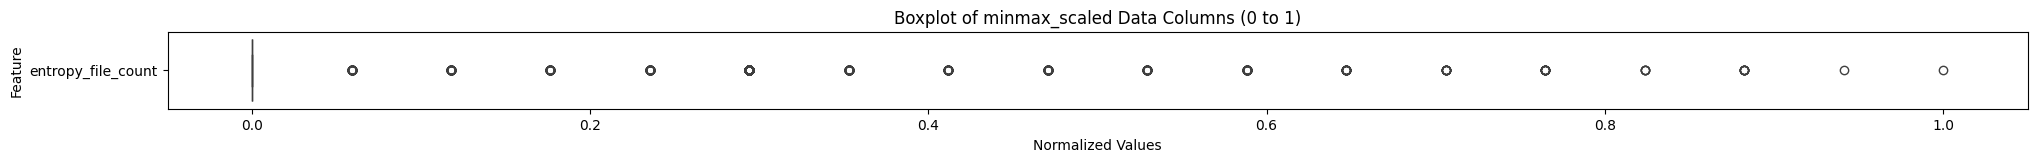

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(24, vectors_scaled.shape[1]//2))
sns.boxplot(data=vectors_scaled, native_scale=True, orient="h")  # x="class", y="age", legend="full", 

plt.ylabel('Feature')
# plt.xticks(rotation=45)
plt.xlabel('Normalized Values')

plt.title('Boxplot of minmax_scaled Data Columns (0 to 1)')
plt.show()

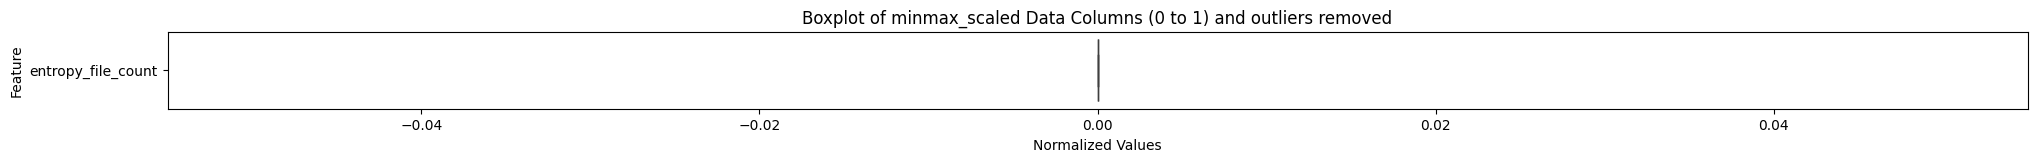

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(24, vectors_scaled.shape[1]//2))
sns.boxplot(data=vectors_robust_scaled, native_scale=True, orient="h")  # x="class", y="age", legend="full", 

plt.ylabel('Feature')
# plt.xticks(rotation=45)
plt.xlabel('Normalized Values')

plt.title('Boxplot of minmax_scaled Data Columns (0 to 1) and outliers removed')
plt.show()

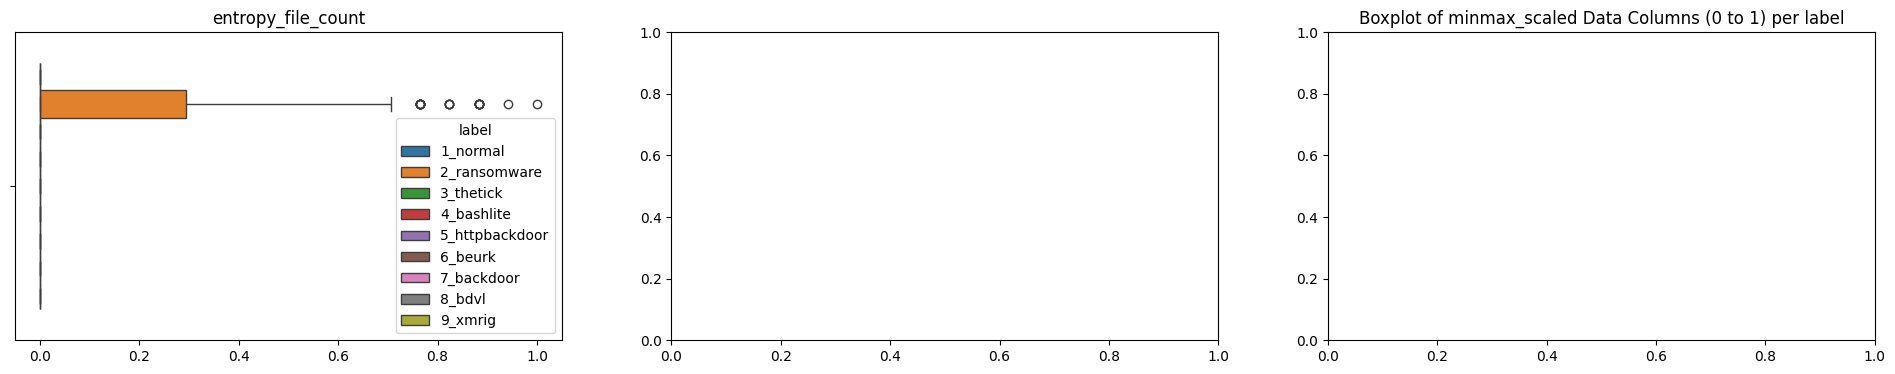

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

figcount_x = 3
figcount_y = (vectors_scaled.shape[1] + 2) // figcount_x
fig, axs = plt.subplots(figcount_y, figcount_x, figsize=(24, figcount_y * 4))
axs = axs.flatten()

for i, column in enumerate(vectors_scaled.columns):
    if column == "label":
        continue

    sns.boxplot(data=vectors_scaled, x=column, ax=axs[i], hue="label", native_scale=True, orient="h",
                legend=True)
    axs[i].set_title(f'{column}')
    axs[i].set_xlabel('')

plt.title('Boxplot of minmax_scaled Data Columns (0 to 1) per label')
plt.show()